In [104]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import sklearn
import tabulate
import itertools
from mpl_toolkits import mplot3d
import umap
import scipy
import networkx as nx
from importlib import reload
from sklearn.neighbors import radius_neighbors_graph
from scipy import stats
import matplotlib.image as mpimg

# locals
import utils as ut
reload(ut)

sc.settings.verbosity = 3

In [2]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [3]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/"

adata = {}

for f in os.listdir(dirPath):
    
    if not f == "all":
        key = f
        mtxPath = f"{dirPath}{f}/outs/"
        data = sc.read_visium(mtxPath)
        data.var_names_make_unique()
        data.var_names = [x.upper() for x in data.var_names]
        adata[key] = data
    
adata.keys()

reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD14/outs/filtered_feature_bc_matrix.h5
 (0:00:00)
reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/ND/outs/filtered_feature_bc_matrix.h5


/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:00)


/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading /nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/SPT/HFD8/outs/filtered_feature_bc_matrix.h5
 (0:00:00)


/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['HFD14', 'ND', 'HFD8'])

# Filtering

In [4]:
keys = ['ND', 'HFD8', 'HFD14']

min_counts = 10

for key in keys:
    print(key)
    data = adata[key]
    sc.pp.filter_cells(data, min_counts=min_counts)
    sc.pp.normalize_total(data, target_sum=1e4) # Normalize each cell by total counts over all genes
    sc.pp.log1p(data) # Logarithmize data via `X = \log(X + 1)`,
    sc.pp.scale(data) # unit variance and zero mean


ND
filtered out 1 cells that have less than 10 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD8
filtered out 2 cells that have less than 10 counts
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
HFD14
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2000, 1681, 3)
ND TREM2 (0.001)
ND CD9 (0.004)


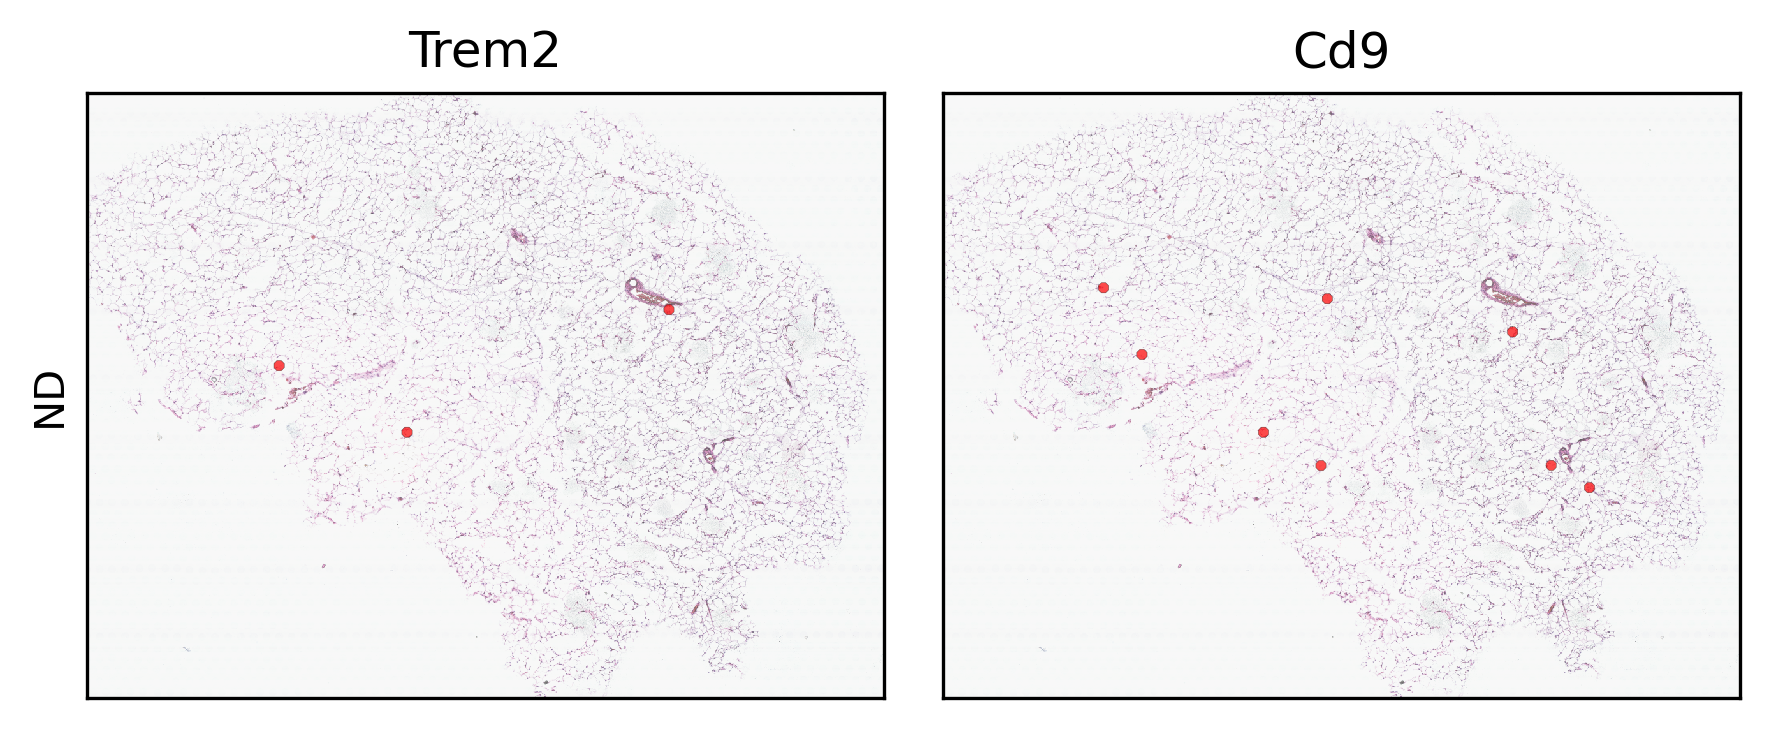

(2000, 1692, 3)
HFD8 TREM2 (0.047)
HFD8 CD9 (0.044)


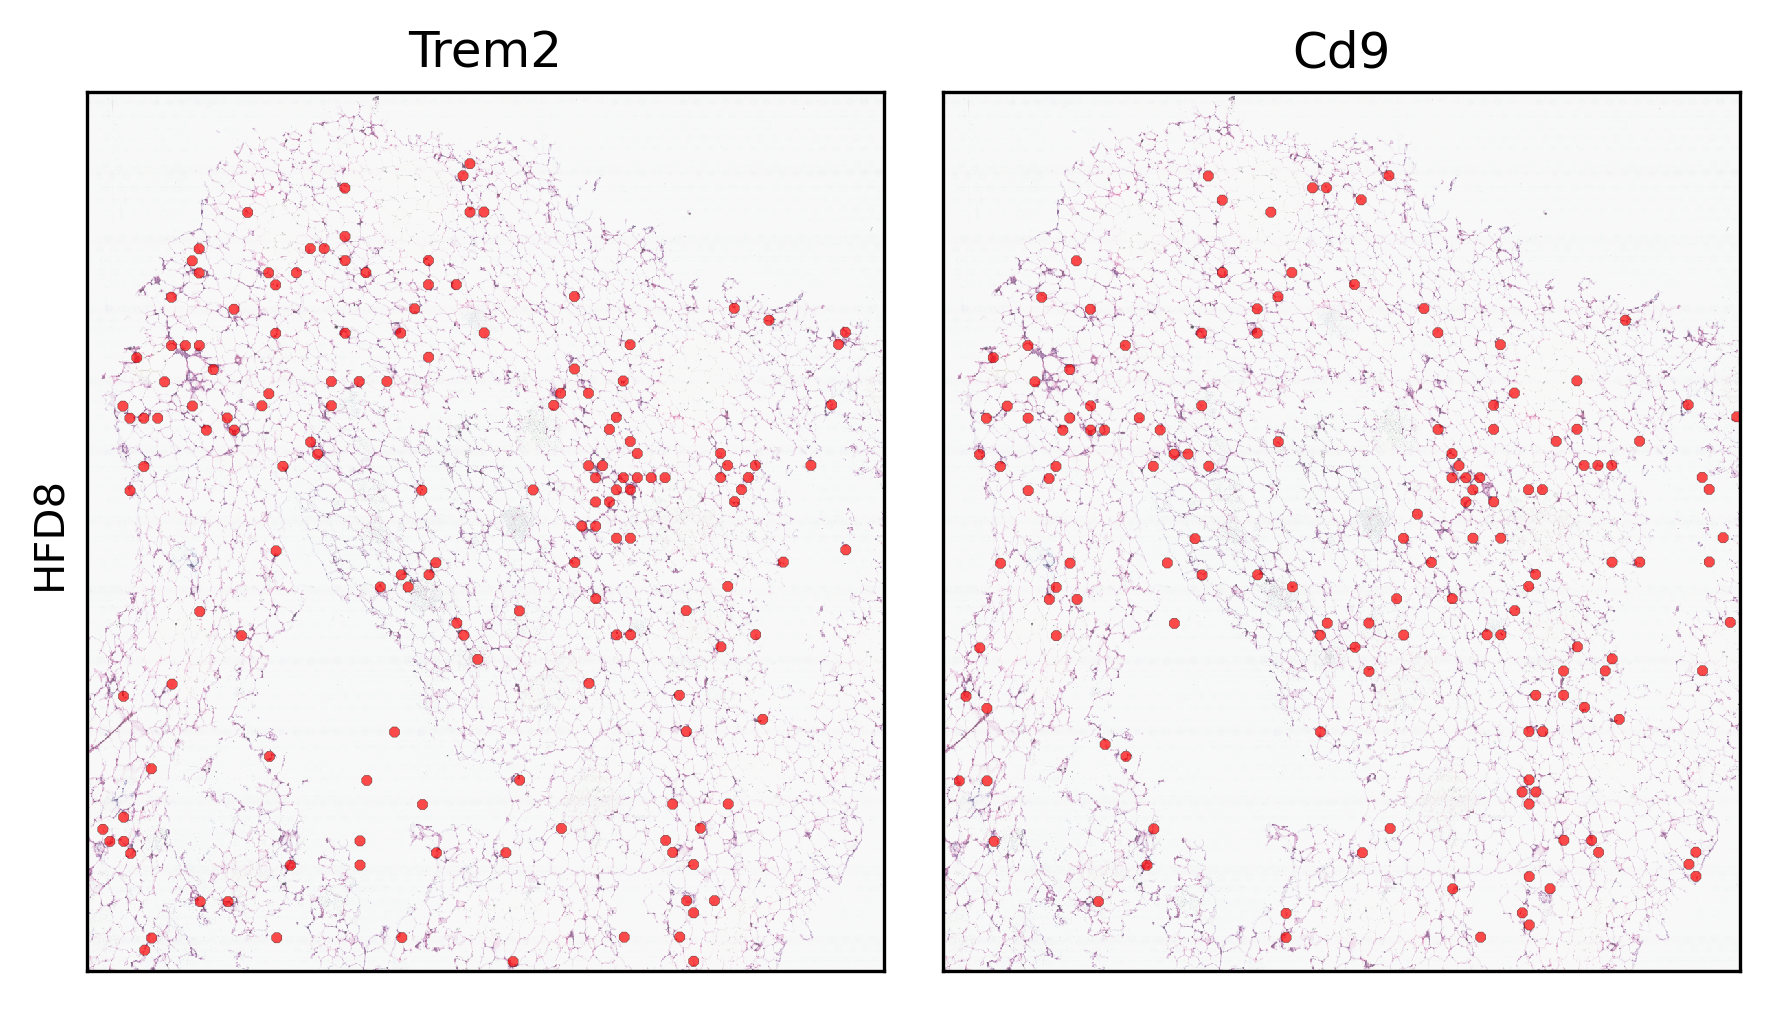

(2000, 1628, 3)
HFD14 TREM2 (0.140)
HFD14 CD9 (0.140)


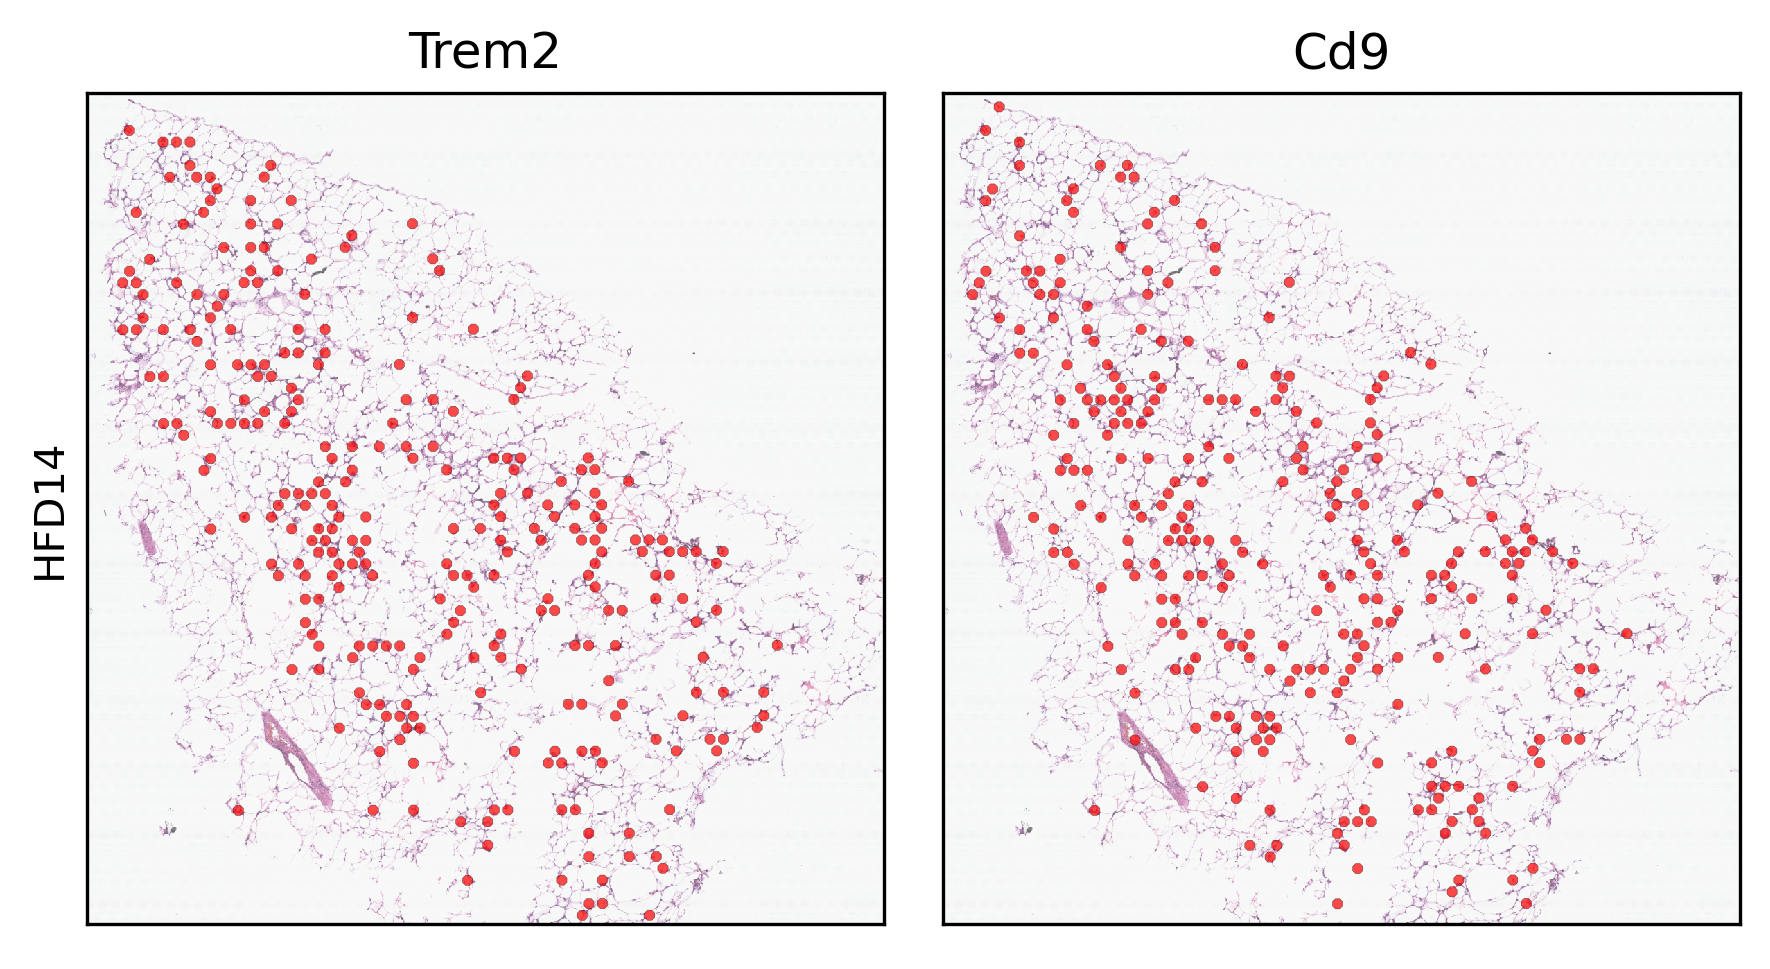

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

query = ['TREM2', 'CD9']


def getImage(data):
    """A function to get image from the spatial data """
    from scanpy.pl._tools import scatterplots as spt    
    sptData = data.uns['spatial']
    
    libraryId = list(sptData.keys())[0]
    sptData = sptData[libraryId]
    
    # get params
    img = sptData['images']['hires']
    scale_factor = sptData['scalefactors']['tissue_hires_scalef']
    return img, scale_factor


trim = {
    'ND' : {'xlim' :  [250, 1500], 'ylim' : [1600, 650]},
    'HFD8' : {'xlim' :  [190, 1350], 'ylim' : [1680, 400]},
    'HFD14' : {'xlim' :  [250, 1400], 'ylim' : [1650, 450]},
}


for key in keys:
    data = adata[key]

    # get the image and the scale factors
    img, scale_factor = getImage(data)
    
    # get the data
    df = data.to_df()
    
    # get genes for cell types
    tf = cf[cf['key'] == key]
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    print(img.shape)
    
    
    fig, axs = plt.subplots(1, len(query), sharey=True)
    axs = axs.ravel()
    
    for i, q in enumerate(query):
        color = df[q.upper()]
        mask = color > 0
        print(f"{key} {q} ({np.sum(mask) / len(mask):.3f})")
        color = ['r'] * np.sum(mask)

        # plot the spots
        axs[i].scatter(x[mask], 
                    y[mask],
                    c=color,
                    marker="8",
                    edgecolor="k",
                    lw=0.1,
                    zorder=2,
                    alpha=0.7,
                    s=7)

        # plot the plate
        axs[i].imshow(img.astype(float), 
                   interpolation='none',
                   cmap='binary',
                   alpha=0.7,
                   zorder=1)
    
        xlim = trim[key]['xlim']
        ylim = trim[key]['ylim']
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        axs[i].set_aspect("equal")
        axs[i].set_title(str(q).lower().capitalize())
        axs[i].set_yticks([])
        axs[i].set_xticks([])
        
        if i == 0:
            axs[i].set_ylabel(key)
            
    plt.tight_layout()
    plt.show()
    
    # break

In [142]:
keys = ['HFD8']

query = ["TREM2", 'CD9']

for key in keys:
    data = adata[key]

    # get the image and the scale factors
    img, scale_factor = getImage(data)
    
    # get the data
    df = data.to_df()
    
    # get genes for cell types
    tf = cf[cf['key'] == key]
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    zeta = df[query].apply(lambda x: map(x, *))
    
    points = pd.DataFrame({"x" : y, "y" : x})
    # points = points.sort_values(by='x')
    points = points.reset_index(drop=True)
    
    # get neighbors within distance radius
    radius = 30
    A = radius_neighbors_graph(points[['x', 'y']], radius=radius)
    G = nx.from_scipy_sparse_matrix(A)
    
    # add the positions
    pos = {}
    for idx, row in points.iterrows():
        pos[idx] = np.array(row[['x', 'y']])

    G.pos = pos 
    
    plt.rcParams['figure.figsize'] = 10, 10
    nx.draw_networkx_nodes(G,
                           pos=G.pos,
                           node_size=30,
                           cmap='Reds',
                           node_color=zeta,
                           edgecolors='k')

    nx.draw_networkx_edges(G,pos=G.pos)
    
    
# #     fig = plt.figure()
# #     ax = fig.add_subplot(projection='3d')
    
# #     ax.plot_trisurf(x, y, color,
# #                 cmap='viridis', edgecolor='none');
    
#     # ax.scatter(x, y, color, marker="o", c=color)

#     plt.scatter(x, 
#                 y,
#                 c=color,
#                 cmap='Reds',
#                 marker="o",
#                 edgecolor="None",
#                 lw=0.1,
#                 zorder=2,
#                 alpha=0.8,
#                 s=3)
    
#     _ = plt.xlabel("")
#     _ = plt.ylabel("")
    
  

SyntaxError: iterable argument unpacking follows keyword argument unpacking (3394755857.py, line 24)

HFD8 CD9 (0.047)
3392 3392 3392


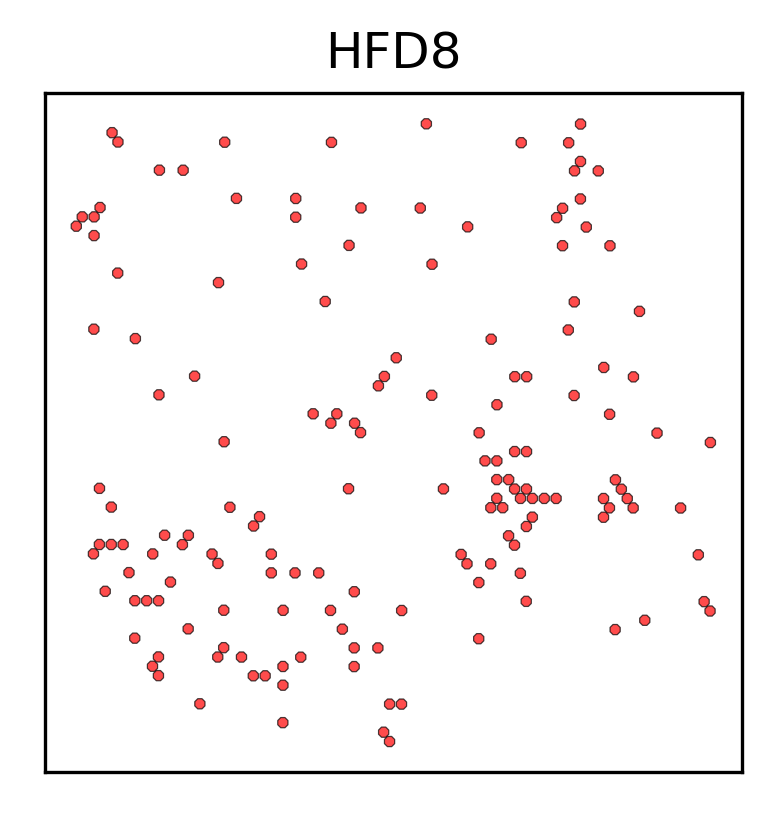

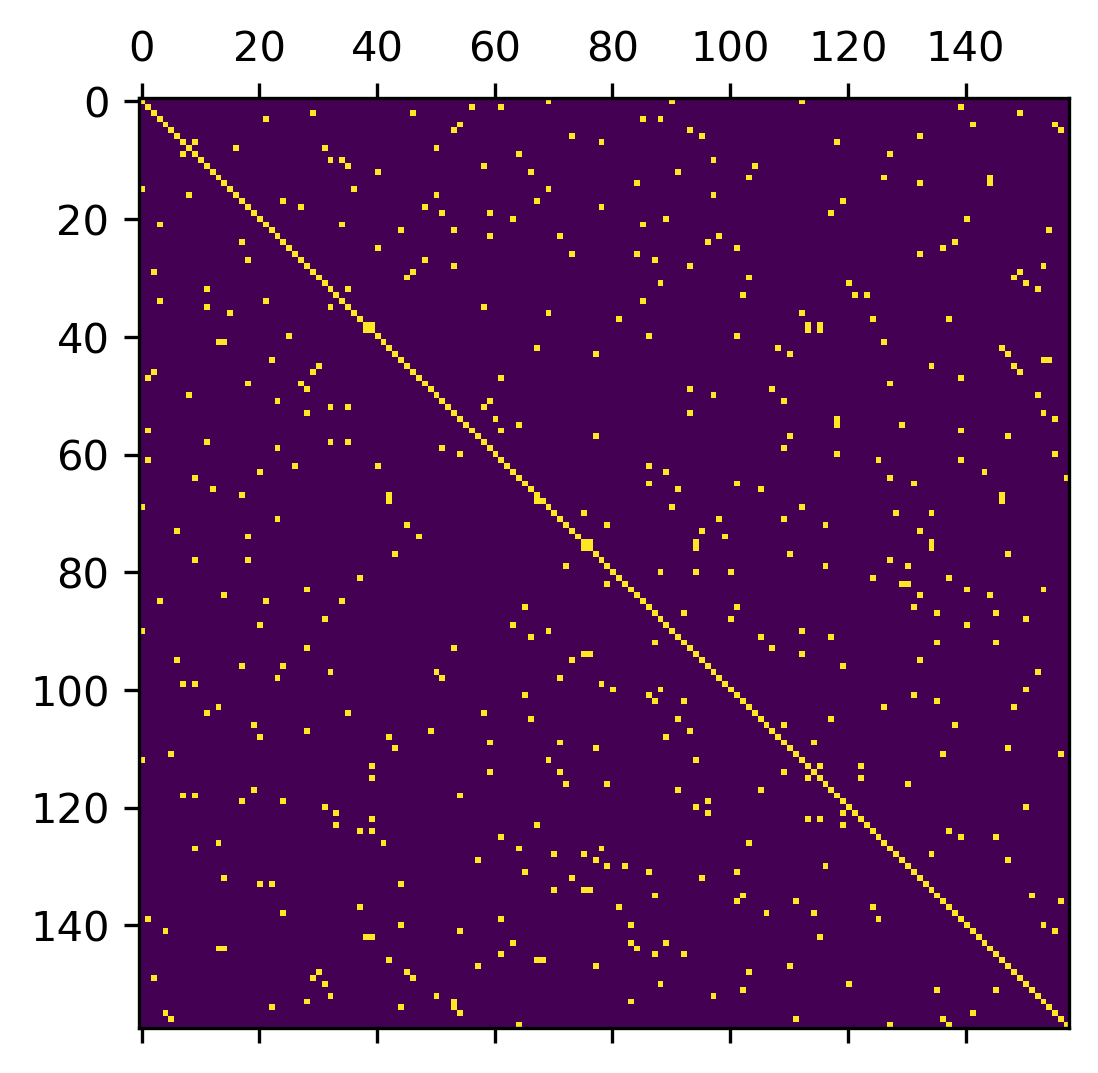

In [132]:
"""Plot like a graph """

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

query = 'TREM2'


def getImage(data):
    """A function to get image from the spatial data """
    from scanpy.pl._tools import scatterplots as spt    
    sptData = data.uns['spatial']
    
    libraryId = list(sptData.keys())[0]
    sptData = sptData[libraryId]
    
    # get params
    img = sptData['images']['hires']
    scale_factor = sptData['scalefactors']['tissue_hires_scalef']
    return img, scale_factor


trim = {
    'ND' : {'xlim' :  [250, 1500], 'ylim' : [1600, 650]},
    'HFD8' : {'xlim' :  [190, 1350], 'ylim' : [1680, 400]},
    'HFD14' : {'xlim' :  [250, 1400], 'ylim' : [1650, 450]},
}

keys = ['HFD8']
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = 'w'
for key in keys:
    data = adata[key]

    # get the image and the scale factors
    img, scale_factor = getImage(data)
    
    # get the data
    df = data.to_df()
    
    # get genes for cell types
    tf = cf[cf['key'] == key]
    
    # get the image coordinates and scale them
    coords = data.obsm['spatial']
    x = coords[:, 0]
    y = coords[:, 1]
    x = x * scale_factor 
    y = y * scale_factor 
    
    color = df[query.upper()]
    mask = color > 0
    print(f"{key} {q} ({np.sum(mask) / len(mask):.3f})")
    color = ['r'] * np.sum(mask)
    
    print(len(mask), len(x), len(y))

    # plot the spots
    plt.scatter(x[mask], 
                y[mask],
                c=color,
                marker="8",
                edgecolor="k",
                lw=0.3,
                zorder=2,
                alpha=0.7,
                s=7)
    
    _ = plt.xticks([])
    _ = plt.yticks([])
    plt.title(key)
    plt.show()
    
    X = np.column_stack((x[mask], y[mask]))
    
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)
    
#     for x, y in enumerate(X):
        
        
    
#     print(indices)
    
    A = nbrs.kneighbors_graph(X).toarray()
    
    
    # print(indices)
    plt.matshow(A)
    
    
    